<a href="https://colab.research.google.com/github/stoic-edu/aes_project/blob/main/6_kmeans_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering using the k-Means Clustering Algorithm

| Key              | Value                                                                                                                                                                                                                                                                                                        |
|:-----------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Course Codes** | BBT 4206 and BFS 4102                                                                                                                                                                                                                                                                                        |
| **Course Names** | BBT 4206: Business Intelligence II (Week 1-3 of 13) and<br/>BFS 4102: Advanced Business Data Analytics (Week 4-6 of 13)                                                                                                                                                                                      |
| **Semester**     | August to November 2025                                                                                                                                                                                                                                                                                      |
| **Lecturer**     | Allan Omondi                                                                                                                                                                                                                                                                                                 |
| **Contact**      | aomondi@strathmore.edu                                                                                                                                                                                                                                                                                       |
| **Note**         | The lecture contains both theory and practice.<br/>This notebook forms part of the practice.<br/>It is intended for educational purposes only.<br/>Recommended citation: [BibTex](https://raw.githubusercontent.com/course-files/ClusteringandAssociationRuleMining/refs/heads/main/RecommendedCitation.bib) |
| **Student ID:**  |                                                                                                                                                                                                                                                                                                              |
| **Name**         |                                                                                                                                                                                                                                                                                                              |

**Business context**: A business aims to refine its marketing strategy by grouping customers into distinct segments based on _demographic details_ and _spending behavior_. This segmentation strategy serves as a foundation for implementing highly personalized marketing campaigns, where the leading KPI is the _customer engagement with tailored adverts_, and the lagging KPI is the _increase in overall customer spending_. By identifying specific customer clusters, the marketing team can optimize advertising efforts to target each group more effectively, ultimately driving increased customer satisfaction and revenue.

**Dataset**: The dataset used is based on the **"Mall Customers"** dataset, which consists of 200 observations. Each observation represents a customer, and the dataset includes demographic and behavioral features that are essential for customer segmentation.

| **Feature Type** | **Feature Name**         | **Description**                                                                              |
|:-----------------|:-------------------------|:---------------------------------------------------------------------------------------------|
| **Feature**      | `CustomerID`             | A unique identifier assigned to each customer                                                |
| **Feature**      | `Genre`                  | Gender of the customer (Male or Female)                                                      |
| **Feature**      | `Age`                    | Age of the customer in years                                                                 |
| **Feature**      | `Annual Income (k$)`     | Annual income of the customer in thousands of dollars                                        |
| **Feature**      | `Spending Score (1-100)` | Spending behavior of the customer on a scale of 1 to 100, with 100 being the highest spender |

Suppose that the dataset has been provided by the organization's customer service department for clustering purposes. This is done to segment customers into distinct groups based on their demographics (`Age`, `Genre`) and spending behaviors (`Annual Income`, `Spending Score`).

`import pandas as pd`
- 'Pandas' is essential because it is used for:
    - Loading the CSV data (`pd.read_csv()`)
    - Data manipulation and analysis
    - Creating and managing DataFrames
    - Essential for structured data analysis, e.g., `Group By` operations

`import matplotlib.pyplot as plt`
- 'Matplotlib' is used for:
    - Visualising data
    - Plotting graphs (e.g., scatter plots, line plots, the elbow method graph)
    - Customising visualisations (labels, titles, legends)

`from sklearn.preprocessing import StandardScaler, MinMaxScaler`
- 'StandardScaler' is used for:
    - Scaling features to have a mean of 0 and standard deviation of 1
    - This **data transformation** (referred to as standardization) is necessary to ensure that all features contribute equally to the distance calculations when clustering
- 'MinMaxScaler' is used for:
    - Normalization to ensure numeric features range between 0 and 1
- One-Hot encoding is another data transformation technique that converts categorical variables into binary vectors. It is not applied in this case

`from sklearn.cluster import KMeans`
- 'KMeans' is used for:
    - Performing K-Means clustering
    - Finding clusters in the data based on the features provided
    - The `fit_predict()` method can then be used to fit the model and predict cluster labels for each data point

`import seaborn as sns`
- 'Seaborn' is used for:
    - Enhanced data visualisation
    - Creating more aesthetically pleasing and informative plots (e.g., histograms, box plots, heatmaps)
    - It provides a high-level interface for drawing attractive statistical graphics

`import warnings`
`warnings.filterwarnings('ignore')`
- 'Warnings' is used to suppress warnings that may arise during the execution of the code, such as convergence warnings from K-Means. Even though it is not necessary for the clustering, it helps keep the output clean and focused on the results.

## Step 1: Import the necessary libraries

In [1]:
# For file and system operations
import urllib.request
import os

# For data manipulation
import pandas as pd
import numpy as np

# For statistical data analysis
from scipy.stats import kurtosis
from scipy.stats import skew

# For data preprocessing and transformation
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler

# For Machine Learning
from sklearn.cluster import KMeans

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For model persistence
import joblib

# For suppressing warnings
import warnings
warnings.filterwarnings('ignore')

## Step 2: Load the data

In [2]:
dataset_path = './data/mall_customers.csv'
url = 'https://raw.githubusercontent.com/course-files/ClusteringandAssociationRuleMining/refs/heads/main/data/mall_customers.csv'

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    if not os.path.exists('./data'):
        os.makedirs('./data')
    urllib.request.urlretrieve(url, dataset_path)
    print("✅ Dataset downloaded")
else:
    print("✅ Dataset already exists locally")

use_cols = ['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
customer_data = pd.read_csv(dataset_path, usecols=use_cols, encoding='utf-8', nrows=200000)

✅ Dataset downloaded


### Identify the numeric and categorical columns

**Selection of numeric columns**
- The code identifies columns with numeric data types (`int64` and `float64`) that can be subjected to mathematical or statistical functions.
- The code also identifies non-numeric columns (e.g., `strings`, `objects`, etc.) by excluding numeric (`int64`, `float64`) and `datetime` data types.
- This is done using `select_dtypes()` method of the DataFrame, which filters columns based on their data types.

In [3]:
numeric_cols = customer_data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = customer_data.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).columns

print("\nThe identified numeric columns are:")
print(numeric_cols.tolist())

print("\nThe identified categorical columns is/are:")
print(categorical_cols.tolist())


The identified numeric columns are:
['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

The identified categorical columns is/are:
['Genre']


## Step 3: Initial Exploratory Data Analysis (EDA)

In [4]:
print("\n*1* The number of observations and variables")
display(customer_data.shape)

print("\n*2* The data types:")
display(customer_data.info())

print("\n*3* The summary of the numeric columns:")
display(customer_data.describe())

print("\n*4* The whole dataset:")
display(customer_data)

print("\n*5* The first 5 rows in the dataset:")
display(customer_data.head())

print("\n*6* Percentage distribution for each category")
print("\nNumber of observations per class:")
print("Frequency counts:\n", customer_data['Genre'].value_counts())
print("\nPercentages:\n", customer_data['Genre'].value_counts(normalize=True) * 100, "%")


*1* The number of observations and variables


(200, 5)


*2* The data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


None


*3* The summary of the numeric columns:


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000



*4* The whole dataset:


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18



*5* The first 5 rows in the dataset:


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



*6* Percentage distribution for each category

Number of observations per class:
Frequency counts:
 Genre
Female    112
Male       88
Name: count, dtype: int64

Percentages:
 Genre
Female    56.0
Male      44.0
Name: proportion, dtype: float64 %


### Measures of Distribution

#### Variance of numeric columns

In [5]:
print("\nVariance of numeric columns:")
print(customer_data[numeric_cols].var())


Variance of numeric columns:
CustomerID                3350.000000
Age                        195.133166
Annual Income (k$)         689.835578
Spending Score (1-100)     666.854271
dtype: float64


#### Standard deviation of numeric columns

In [6]:
print("\nStandard deviation of numeric columns:")
print(customer_data[numeric_cols].std())


Standard deviation of numeric columns:
CustomerID                57.879185
Age                       13.969007
Annual Income (k$)        26.264721
Spending Score (1-100)    25.823522
dtype: float64


#### Kurtosis of numeric columns

In [7]:
print("\nFisher Kurtosis of numeric columns:")
print("\nInterpretation:")
print("→ Positive kurtosis indicates heavier tails (more outliers) than what is expected in a normal distribution - leptokurtic")
print("→ Negative kurtosis indicates lighter tails (less outliers) than what is expected in a normal distribution - platykurtic")
print("→ A normal distribution has kurtosis of 0 - mesokurtic")
print("\nKurtosis values:")
print(customer_data[numeric_cols].apply(lambda x: kurtosis(x, fisher=True)))


Fisher Kurtosis of numeric columns:

Interpretation:
→ Positive kurtosis indicates heavier tails (more outliers) than what is expected in a normal distribution - leptokurtic
→ Negative kurtosis indicates lighter tails (less outliers) than what is expected in a normal distribution - platykurtic
→ A normal distribution has kurtosis of 0 - mesokurtic

Kurtosis values:
CustomerID               -1.200060
Age                      -0.684751
Annual Income (k$)       -0.125893
Spending Score (1-100)   -0.835958
dtype: float64


#### Skewness of numeric columns

In [8]:
print("\nSkewness of numeric columns:")
print("\nInterpretation:")
print("→ Positive skewness indicates a long right tail (right-skewed distribution)")
print("→ Negative skewness indicates a long left tail (left-skewed distribution)")
print("→ Skewness close to 0 indicates a symmetric distribution")
print("\nSkewness values:")
print(customer_data[numeric_cols].apply(lambda x: skew(x)))


Skewness of numeric columns:

Interpretation:
→ Positive skewness indicates a long right tail (right-skewed distribution)
→ Negative skewness indicates a long left tail (left-skewed distribution)
→ Skewness close to 0 indicates a symmetric distribution

Skewness values:
CustomerID                0.000000
Age                       0.481919
Annual Income (k$)        0.319424
Spending Score (1-100)   -0.046865
dtype: float64


### Measures of Relationship

#### Covariance matrix of numeric features

In [9]:
print("\nCovariance matrix of numeric features:")
print("\nInterpretation:")
print("→ Positive values indicate that variables move in the same direction")
print("→ Negative values indicate that variables move in opposite directions")
print("→ Values close to 0 indicate little to no linear relationship")
print("\nCovariance values:")
display(customer_data[numeric_cols].cov())


Covariance matrix of numeric features:

Interpretation:
→ Positive values indicate that variables move in the same direction
→ Negative values indicate that variables move in opposite directions
→ Values close to 0 indicate little to no linear relationship

Covariance values:


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,3350.000000,-21.638191,1486.050251,20.678392
Age,-21.638191,195.133166,-4.548744,-118.040201
Annual Income (k$),1486.050251,-4.548744,689.835578,6.716583
Spending Score (1-100),20.678392,-118.040201,6.716583,666.854271


#### Correlation matrix of numeric features

In [10]:
print("\nSpearman correlation matrix of numeric features:")
spearman_corr = customer_data[numeric_cols].corr(method='spearman')
print("\nInterpretation:")
print("→ Values range from -1 to +1")
print("→ +1 indicates perfect positive correlation")
print("→ -1 indicates perfect negative correlation")
print("→ 0 indicates no correlation")
print("\nCorrelation values:")
display(spearman_corr)


Spearman correlation matrix of numeric features:

Interpretation:
→ Values range from -1 to +1
→ +1 indicates perfect positive correlation
→ -1 indicates perfect negative correlation
→ 0 indicates no correlation

Correlation values:


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,1.000000,0.015249,0.999638,0.013149
Age,0.015249,1.000000,0.019767,-0.344940
Annual Income (k$),0.999638,0.019767,1.000000,0.007840
Spending Score (1-100),0.013149,-0.344940,0.007840,1.000000


### Basic visualization of the data

#### Histograms

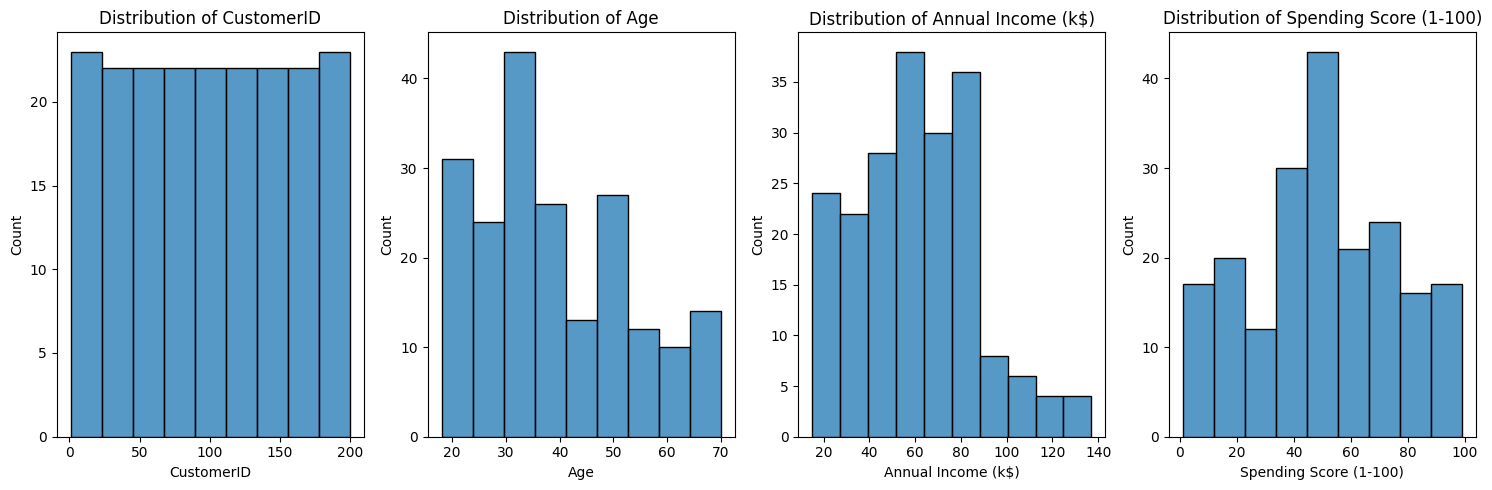

In [11]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    sns.histplot(data=customer_data, x=col)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

#### Box plots

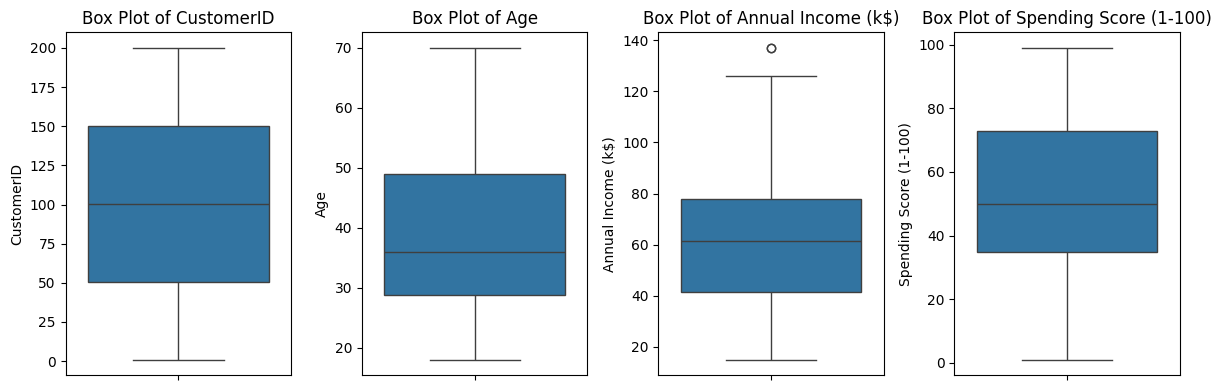

In [12]:
plt.figure(figsize=(12, 4))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    sns.boxplot(data=customer_data, y=col)
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()


#### Missing data plot

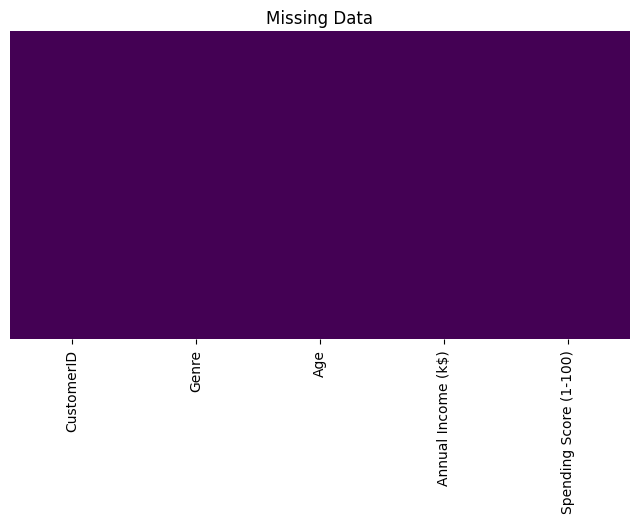

In [13]:
plt.figure(figsize=(8, 4))
sns.heatmap(customer_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Data')
plt.show()

#### Correlation heatmap

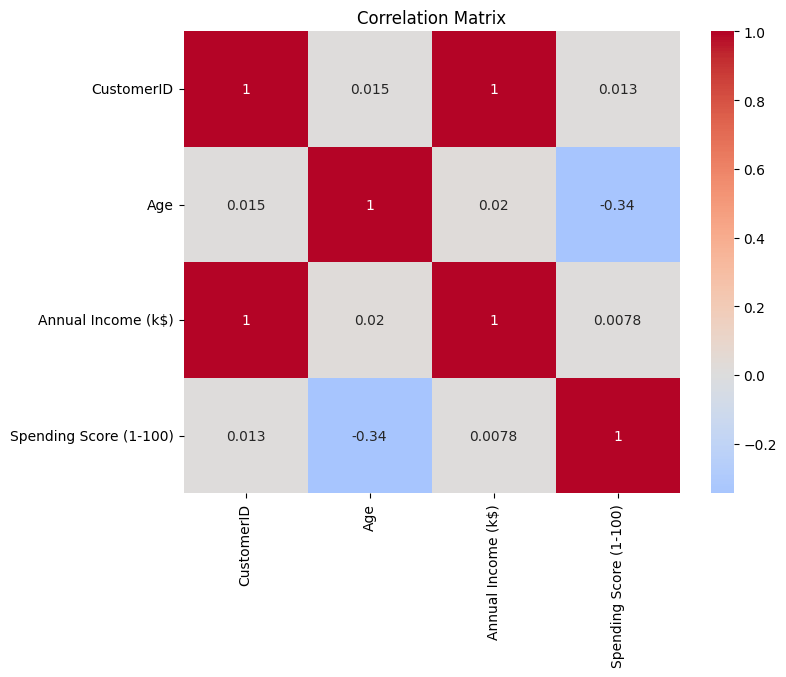

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

#### Scatter plot matrix

<Figure size 1000x1000 with 0 Axes>

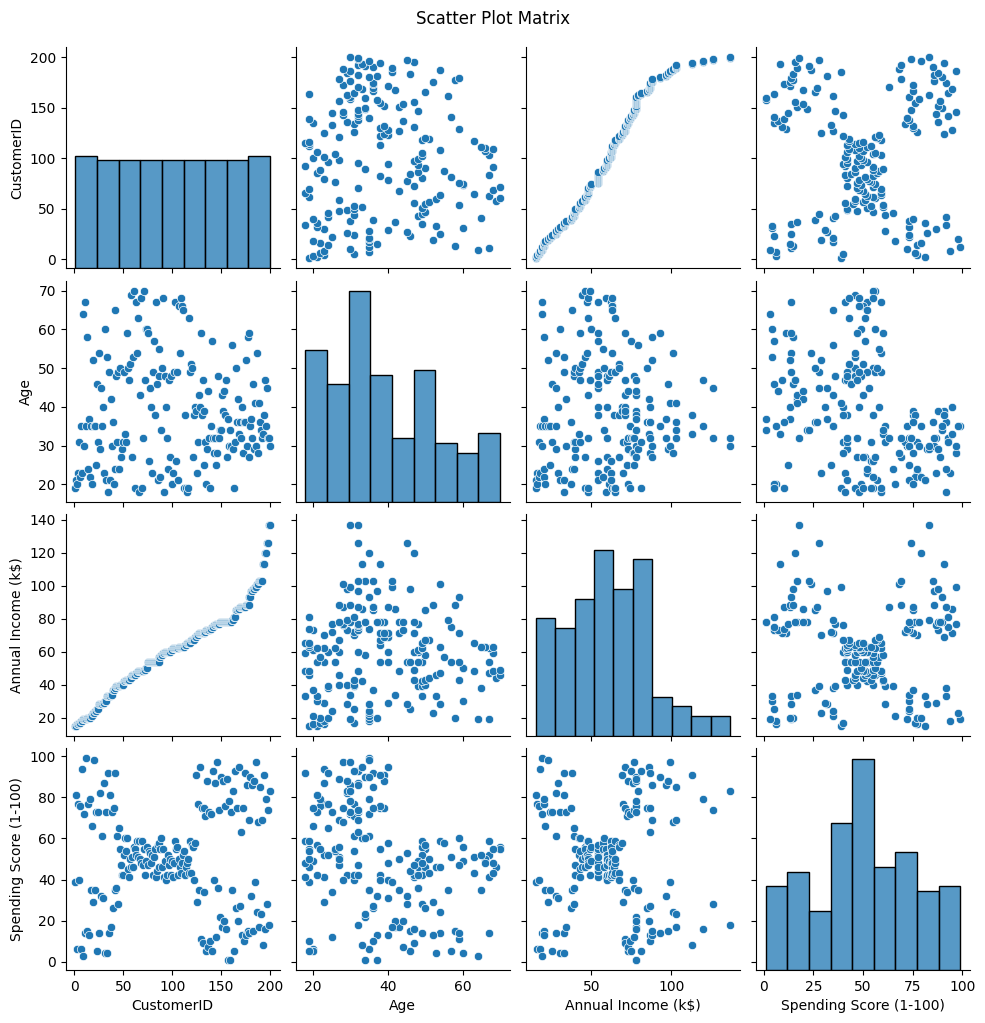

In [15]:
plt.figure(figsize=(10, 10))
sns.pairplot(customer_data[['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
plt.suptitle('Scatter Plot Matrix', y=1.02)
plt.show()

## Step 4: Feature selection for clustering
We will use **Age**, **Annual Income (KES)**, and **Spending Score (1‑100)**.

In [16]:
X = customer_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].copy()
X.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


## Step 5: Data transformation

In [23]:
# Option 1: Standardize (mean=0, variance=1)
scaler_standard = StandardScaler()
X_scaled = scaler_standard.fit_transform(X)
print("\nStandardized data (mean=0, variance=1):")

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print("\nFirst 5 rows:")
display(X_scaled_df.head())
print("\nMean and standard deviation:")
display(X_scaled_df.describe())


# Option 2: Normalize (scale between 0 and 1) - this is optional for k-Means
# normalizer = MinMaxScaler()
# X_normalized = normalizer.fit_transform(X)
# print("\nNormalized data (scale between 0 and 1):")
# print(X_normalized)


Standardized data (mean=0, variance=1):

First 5 rows:


,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980



Mean and standard deviation:


,Age,Annual Income (k$),Spending Score (1-100)
count,2.000000e+02,2.000000e+02,2.000000e+02
mean,-1.021405e-16,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,7.284319e-01,6.656748e-01,8.851316e-01
max,2.235532e+00,2.917671e+00,1.894492e+00


## Step 6: Determine the optimal number of clusters using the Elbow method

1. **Inertia Calculation Loop:**
   - Creates an empty list `inertia` to store the sum of squared distances
   - Loops through k values from 1 to 10 using `range(1,11)`
   - For each k value:
     - Creates a KMeans model with k clusters
     - Fits the model to the scaled data
     - Adds the inertia (Within-Cluster Sum of Squares [WCSS]) to the list
          - **Within-Cluster Sum of Squares (WCSS)**, also known as **inertia**, measures the compactness of clusters in a clustering algorithm. It represents the sum of the squared distances between each data point in a cluster and the centroid of that cluster. A lower WCSS indicates that the data points within each cluster are closer to their respective centroid, suggesting tighter, more compact clusters.

2. **Visualization:**
   - Creates a figure of size 6x4
   - Plots k values (x-axis) against inertia values (y-axis)
   - Adds markers 'o' at each point
   - Labels axes and adds title
   - Displays the plot

3. **Purpose:**
   - The Elbow Method helps in finding the optimal number of clusters
   - The "elbow" in the plot indicates where adding more clusters gives diminishing returns
   - Point where the line starts to level out suggests optimal k value

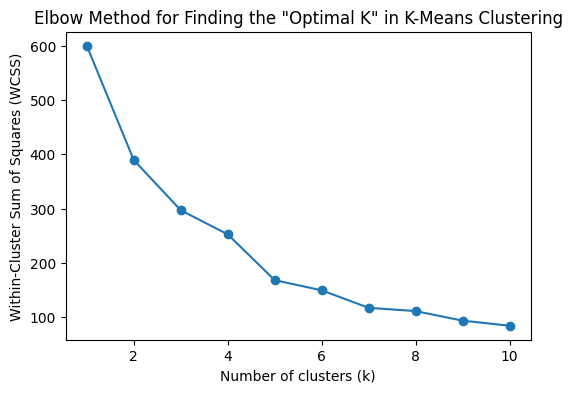

In [18]:
inertia = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=53)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Finding the \"Optimal K\" in K-Means Clustering')
plt.show()

Based on the elbow plot, **k = 5** gives the ideal number of clusters; where adding more clusters does not significantly improve tightness.

## Step 7: Apply K-Means clustering using the optimal number of clusters

In [19]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=53)
clusters = kmeans.fit_predict(X_scaled)
customer_data['Cluster'] = clusters
customer_data.head()
customer_data.to_csv('./data/mall_customers_with_clusters.csv')

## Step 8: Visualize the clusters

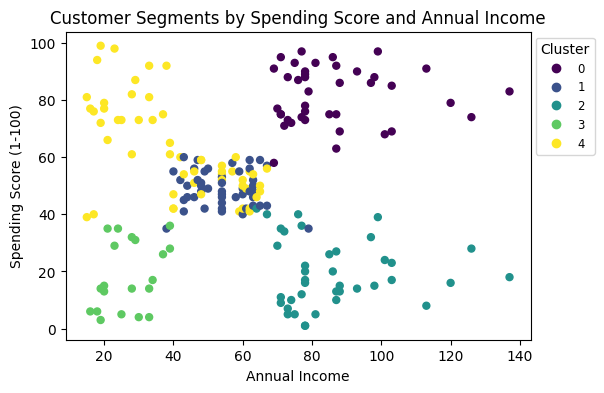

In [20]:
plt.figure(figsize=(6,4))
scatter = plt.scatter(customer_data['Annual Income (k$)'],
                      customer_data['Spending Score (1-100)'],
                      c=customer_data['Cluster'], s=25)
plt.xlabel('Annual Income')
plt.ylabel('Spending Score (1‑100)')
plt.title('Customer Segments by Spending Score and Annual Income')
plt.legend(*scatter.legend_elements(), title='Cluster', loc='upper right',
           bbox_to_anchor=(1.15, 1), fontsize='small')
plt.show()

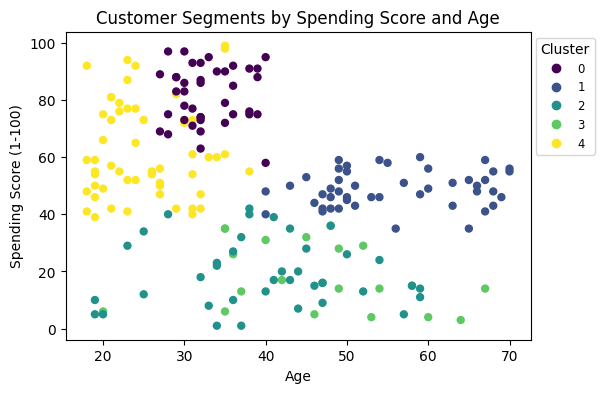

In [21]:
plt.figure(figsize=(6,4))
scatter = plt.scatter(customer_data['Age'],
                      customer_data['Spending Score (1-100)'],
                      c=customer_data['Cluster'], s=25)
plt.xlabel('Age')
plt.ylabel('Spending Score (1‑100)')
plt.title('Customer Segments by Spending Score and Age')
plt.legend(*scatter.legend_elements(), title='Cluster', loc='upper right',
           bbox_to_anchor=(1.15, 1), fontsize='small')
plt.show()

## Step 9: Interpret the clusters (customer segments in the market)

In [22]:
print("\nGender distribution by cluster:")
print(pd.crosstab(customer_data['Cluster'], customer_data['Genre']))
print("\nCluster statistics:")
print("\nMeans:")
display(customer_data.groupby('Cluster').mean(numeric_only=True))
print("\nStandard deviations:")
display(customer_data.groupby('Cluster').std(numeric_only=True))



Gender distribution by cluster:
Genre    Female  Male
Cluster              
0            22    18
1            27    20
2            19    20
3            12     8
4            32    22

Cluster statistics:

Means:


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,,
0,161.025000,32.875000,86.100000,81.525000
1,83.872340,55.638298,54.382979,48.851064
2,159.743590,39.871795,86.102564,19.358974
3,24.100000,46.250000,26.750000,18.350000
4,55.648148,25.185185,41.092593,62.240741



Standard deviations:


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,,
0,23.338630,3.857643,16.339036,9.999968
1,24.425234,8.913657,8.818344,6.303825
2,24.104725,10.938054,16.725013,11.610991
3,12.336936,11.579815,7.311671,11.935242
4,36.656054,5.508395,16.815613,16.596130


| Cluster | Typical age | Gender | Income level | Spending Behaviour |
|---------|-------------|--------|--------------|--------------------|
| 0       | Young       | Both   | High         | Targeted premium   |
| 1       | Young       | Both   | Low–medium   | Average spenders   |
| 2       | Mature      | Both   | High         | Low spenders       |
| 3       | Mature      | Female | Low          | Frugal             |
| 4       | Middle‑age  | Both   | Medium       | Luxury shoppers    |

## Lab Submission Requirements

1. Provide the code to download the `'./data/mall_customers_with_clusters.csv'` file, which contains the original dataset with an additional column for the cluster labels assigned by the K-Means algorithm. This code should work in Google Colab.
2. Provide the code to train a Support Vector Machine (SVM) model using the `X` and `y` variables, where `X` is the feature matrix and `y` is the target variable (the cluster labels). The SVM model should be trained to predict the cluster labels based on the features.
3. Provide the code to demonstrate the prediction of cluster labels using the trained SVM model. This should include a sample input and the predicted cluster label for that input.
4. Submit the link to your notebook via the Google Form provided on Google Classroom. Ensure that you indicate your name and student ID in the notebook.